# Quantitativo Substack mean reversion indicator

Link: https://www.quantitativo.com/p/trading-the-mean-reversion-curve

Features: How probable a price change (return) of X magnitude or more extreme is, in a window of N days, looking back at Y years from the date in question?

Signal: Get the percentile of the 3-day price change on the given date if the 3-day price change is negative (or 100 minus the percentile if the N-day price change is positive). [5 years data]

We divide this value by the area at the left of the zero in the histogram if the 3-day price change is negative (or at the right if it is positive) and multiply by 100.


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import entropy

In [ ]:
stock_ticker = 'MSFT'

stock_data = yf.download(stock_ticker, start='2014-10-01', end='2022-09-25')
stock_data['LogReturn'] = np.log(stock_data['Close']).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [23]:
stock_data['3Return'] = np.log(stock_data['Close']).diff(3)

In [3]:
def MRIndicator(close: pd.Series, window: int=3 , lookback: int=1260) -> pd.Series:
    """
    Calculate the Mean Reversion Indicator (MR) for a given closing price series.  

    Parameters:
        close (pd.Series): Series of closing prices.
        window (int): Number of days for the price change window (default is 3).
        lookback (int): Lookback window size for the histogram (default is 1260).
    
    Returns:
        pd.Series: A series of MR probability values for each rolling lookback window.
    """
    def calculate_mr_prob(rolling_close):
        # Compute percentage changes for the window
        returns = rolling_close.pct_change(window).dropna()
        if len(returns) == 0:
            return np.nan
        
        # Get the rank of each value
        ranks = returns.rank()
        # Calculate percent rank
        percent_ranks = (ranks - 1) / (len(returns) - 1) * 100
        
        # Get the percent rank of a specific value (e.g., 20)
        # percent_rank_of_value = percent_ranks[returns == returns[-1]].iloc[0]
        
        # Calculate the QP value based on the most recent return
        recent_return = returns.iloc[-1]
        
        if recent_return <= 0:
            # Count the number of negative returns within the lookback period
            neg_returns_count = np.sum(returns.iloc[:lookback] <= 0)
            total_count = len(returns.iloc[:lookback])
            
            # Area as the ratio of the count of negative returns to the total count
            area_left_of_zero = neg_returns_count / total_count if total_count != 0 else 1.e-20
            
            # Normalize by dividing the percentile rank by the "area"
            mr_prob = percent_ranks.iloc[-1] / area_left_of_zero
        else:
            # Count the number of positive returns within the lookback period
            pos_returns_count = np.sum(returns.iloc[:lookback] > 0)
            total_count = len(returns.iloc[:lookback])
            
            # Area as the ratio of the count of positive returns to the total count
            area_right_of_zero = pos_returns_count / total_count if total_count != 0 else 1.e-20
            
            # Normalize by dividing by the "area"
            mr_prob = (100 - percent_ranks.iloc[-1]) / area_right_of_zero
        
        return mr_prob

    # Apply rolling with a custom function
    mr_prob_series = close.rolling(window=lookback, min_periods=lookback).apply(
        lambda x: calculate_mr_prob(x)
    )
    
    return mr_prob_series

In [4]:
mr_indicator = MRIndicator(stock_data["Close"])
stock_data["MR"] = mr_indicator
stock_data = stock_data.dropna()

Short signals

In [24]:
stock_data.loc[:,"Short_Signal"] = np.where((stock_data["MR"] < 15.0) & (stock_data["3Return"] < 0.), -1, 0)

# Number of days after a signal to remain active
exit_after_days = 5

# Find indices where signal is -1
short_signal_indices = np.where(stock_data["Short_Signal"] == -1)[0]

# Create a boolean array of the same size as signal_data
adjusted_signal = np.zeros(len(stock_data["Short_Signal"]), dtype=int)

# Propagate the signal for the next `exit_after_days`
for idx in short_signal_indices:
    adjusted_signal[idx:idx + exit_after_days] = -1

# Convert back to pandas Series
short_signal_series = pd.Series(adjusted_signal, index=stock_data["Short_Signal"].index)
stock_data.loc[:,"Short"] = short_signal_series

Long signals

In [25]:
stock_data.loc[:,"Long_Signal"] = np.where((stock_data["MR"] > 85.0) & (stock_data["3Return"] > 0.), 1, 0 )

# Find indices where signal is 1
long_signal_indices = np.where(stock_data["Long_Signal"] == 1)[0]

# Create a boolean array of the same size as signal_data
adjusted_signal = np.zeros(len(stock_data["Long_Signal"]), dtype=int)

# Propagate the signal for the next `exit_after_days`
for idx in long_signal_indices:
    adjusted_signal[idx:idx + exit_after_days] = 1

# Convert back to pandas Series
long_signal_series = pd.Series(adjusted_signal, index=stock_data["Long_Signal"].index)
stock_data.loc[:,"Long"] = long_signal_series

<Axes: xlabel='Date'>

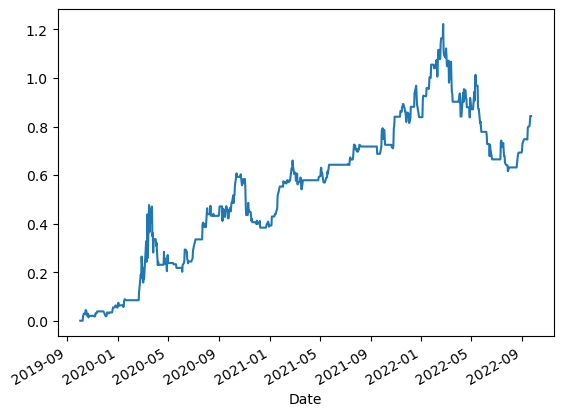

In [26]:
stock_data.loc[:,"LSReturn"] = (stock_data["Long"]+stock_data["Short"])*stock_data['LogReturn']
(np.exp((stock_data["LSReturn"]).cumsum())-1).plot()

# Indicator simple statistics

In [18]:
def calculate_simple_statistics(indicator):
    """
    Range/IQR: A unitless measure of data dispersion relative to its middle 50%.

    Relative Entropy: Measures the difference between two probability distributions; 
    a value of zero indicates identical distributions.
    """
    # Ncases
    ncases = len(indicator)
    # Mean
    mean = np.mean(indicator)
    # Min/Max
    min_val, max_val = np.min(indicator), np.max(indicator)
    # IQR
    q75, q25 = np.percentile(indicator, [75, 25])
    iqr = q75 - q25
    # Range/IQR
    range_iqr = (max_val - min_val) / iqr if iqr != 0 else np.nan
    # Relative Entropy
    hist, bin_edges = np.histogram(indicator, bins=50, density=True)
    uniform_dist = np.ones_like(hist) / len(hist)
    relative_entropy = entropy(hist, uniform_dist)
    
    return {
        "Ncases": ncases,
        "Mean": mean,
        "Min": min_val,
        "Max": max_val,
        "IQR": iqr,
        "Range/IQR": range_iqr,
        "Relative Entropy": relative_entropy,
    }



# Mutual Information Report

In [19]:
def calculate_mutual_information(indicator, target, n_permutations=100):
    """
    High MI scores indicate a strong relationship between the indicator and the target variable, 
    suggesting potential predictive power.
    """
    # Mutual Information Score
    mi_score = mutual_info_regression(indicator.reshape(-1, 1), target)[0]
    
    # Permutations
    permuted_scores = []
    for _ in range(n_permutations):
        permuted_target = np.random.permutation(target)
        permuted_score = mutual_info_regression(indicator.reshape(-1, 1), permuted_target)[0]
        permuted_scores.append(permuted_score)
    
    # Solo p-value
    solo_p_value = np.sum(np.array(permuted_scores) >= mi_score) / n_permutations
    # Unbiased p-value
    unbiased_p_value = (np.sum(np.array(permuted_scores) >= mi_score) + 1) / (n_permutations + 1)
    
    return {
        "MI Score": mi_score,
        "Solo p-value": solo_p_value,
        "Unbiased p-value": unbiased_p_value,
    }

# Serial Correlated Mean Break Test Report

In [20]:
def calculate_serial_mean_break(indicator, nrecent):
    """
    The Serial Correlated Mean Break Test Report identifies potential breaks in the mean of each trading indicator, 
    taking into account serial correlation. This test helps detect significant shifts in the mean over time, 
    indicating nonstationary behavior in the data.

    Parameters:
    nrecent: User-specified number of recent observations.

    Return:
    z(U): Maximum break in the mean. For each potential split point, calculate the difference in means 
          of the two segments and identify the maximum.
    Solo p-value: Measure significance using permutations or analytical methods (e.g., Chow Test).
    Unbiased p-value: Similar adjustment to the Mutual Information Report's unbiased p-value.
    """
    z_values = []
    for split_point in range(1, len(indicator) - nrecent):
        mean1 = np.mean(indicator[:split_point])
        mean2 = np.mean(indicator[split_point:])
        z_values.append(np.abs(mean1 - mean2))
    z_u = max(z_values)
    
    # Permutation testing for p-values
    n_permutations = 100
    permuted_z = []
    for _ in range(n_permutations):
        permuted_indicator = np.random.permutation(indicator)
        permuted_z_values = [
            np.abs(np.mean(permuted_indicator[:split]) - np.mean(permuted_indicator[split:]))
            for split in range(1, len(indicator) - nrecent)
        ]
        permuted_z.append(max(permuted_z_values))
    
    solo_p_value = np.sum(np.array(permuted_z) >= z_u) / n_permutations
    unbiased_p_value = (np.sum(np.array(permuted_z) >= z_u) + 1) / (n_permutations + 1)
    
    return {
        "z(U)": z_u,
        "Solo p-value": solo_p_value,
        "Unbiased p-value": unbiased_p_value,
    }

In [22]:
simple_stats = calculate_simple_statistics(mr_indicator.dropna())
# Target variable is the return
target = stock_data["Close"].loc[mr_indicator.dropna().index].pct_change().dropna()
mutual_info = calculate_mutual_information(mr_indicator.dropna().values[1:], target)
mean_break = calculate_serial_mean_break(mr_indicator.dropna().values, nrecent=25)

print("Simple Statistics Report:", simple_stats)
print("Mutual Information Report:", mutual_info)
print("Serial Mean Break Test Report:", mean_break)

Simple Statistics Report: {'Ncases': 751, 'Mean': 42.5657177612547, 'Min': 0.0, 'Max': 99.4229274286574, 'IQR': 51.322056523253146, 'Range/IQR': 1.93723584290919, 'Relative Entropy': 0.06301399735793668}
Mutual Information Report: {'MI Score': 0.11450275903991969, 'Solo p-value': 0.0, 'Unbiased p-value': 0.009900990099009901}
Serial Mean Break Test Report: {'z(U)': 16.38836832309189, 'Solo p-value': 0.81, 'Unbiased p-value': 0.8118811881188119}
